<a href="https://colab.research.google.com/github/hugojardim/desafio-dt-labs/blob/main/questao-1-colab/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Utilizar o uv por ser extremamente mais performático
%pip install uv
!uv pip install open3d
!uv pip install trimesh
!uv pip install gdown

Using Python 3.11.11 environment at: /usr
Resolved 74 packages in 784ms
⠙ Preparing packages... (0/15)
⠙ Preparing packages... (0/15)
⠙ Preparing packages... (0/15)
dash-core-components ------------------------------     0 B/3.73 KiB
⠙ Preparing packages... (0/15)
dash-core-components ------------------------------ 3.73 KiB/3.73 KiB
⠙ Preparing packages... (0/15)
dash-core-components ------------------------------ 3.73 KiB/3.73 KiB
addict     ------------------------------ 3.74 KiB/3.74 KiB
⠙ Preparing packages... (0/15)
dash-core-components ------------------------------ 3.73 KiB/3.73 KiB
addict     ------------------------------ 3.74 KiB/3.74 KiB
⠙ Preparing packages... (0/15)
dash-core-components ------------------------------ 3.73 KiB/3.73 KiB
addict     ------------------------------ 3.74 KiB/3.74 KiB
comm       ------------------------------ 7.01 KiB/7.01 KiB
⠙ Preparing packages... (0/15)
dash-core-components ------------------------------ 3.73 KiB/3.73 KiB
addict     ----------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import trimesh
import open3d as o3d
import gdown
import zipfile
import numpy as np
import copy
import torch
import os
import glob
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

Definir seed para reprodutibilidade

In [6]:
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Extração dos dados

In [7]:
# Baixar os dados de treino
output_path = '/content/kitti_dataset.zip'
url = f'https://drive.google.com/uc?id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h'

gdown.download(url, output_path, quiet=False)

extract_dir = output_path.replace(".zip", "")
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

folders = sorted(os.listdir(extract_dir))

point_clouds = []
for folder in folders:
    folder_path = os.path.join(extract_dir, folder)
    if os.path.isdir(folder_path):
        points_file = os.path.join(folder_path, f"{folder}_points.obj")
        if os.path.exists(points_file):
            points = np.array(trimesh.load(points_file).vertices)  # Carrega os vértices da nuvem
            point_clouds.append(points)  # Armazena a nuvem de pontos

print(f"Total de nuvens de pontos carregadas: {len(point_clouds)}")

Downloading...
From: https://drive.google.com/uc?id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h
To: /content/kitti_dataset.zip
100%|██████████| 18.0M/18.0M [00:00<00:00, 41.2MB/s]


Total de nuvens de pontos carregadas: 30


In [8]:
# Baixar os dados reais (ground truth)
output_ground_truth_path = '/content/ground_truth.npy'

url = "https://drive.google.com/uc?id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM"
gdown.download(url, output_ground_truth_path, quiet=False)

if os.path.exists(output_ground_truth_path):
    ground_truth = np.load(output_ground_truth_path)
    print(f"Arquivo ground_truth.npy carregado com sucesso: {ground_truth.shape}")
else:
    print("Arquivo ground_truth.npy não encontrado após o download")


Downloading...
From: https://drive.google.com/uc?id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM
To: /content/ground_truth.npy
100%|██████████| 3.97k/3.97k [00:00<00:00, 9.92MB/s]

Arquivo ground_truth.npy carregado com sucesso: (30, 4, 4)


KNN como algoritmo para a busca de vizinhos entre as nuvens

In [9]:
def find_nearest_neighbors_knn(source, target_points):
    # Cria árvore KD para busca de vizinhos na nuvem fonte
    point_cloud_tree = o3d.geometry.KDTreeFlann(source)
    source_points = np.asarray(source.points)  # Converte pontos da fonte para array

    # Arrays para correspondências e distâncias dos vizinhos
    source_corr = np.zeros_like(target_points)
    distances = np.zeros(len(target_points))

    for i, point in enumerate(target_points):
        _, idx, dist = point_cloud_tree.search_knn_vector_3d(point, 1)  # Busca o vizinho mais próximo
        source_corr[i] = source_points[idx[0]]  # Associa o ponto correspondente
        distances[i] = dist[0]  # Armazena a distância

    return source_corr, distances

Pré-processamento com voxel e remoção de outliers

In [10]:
# Cria lista para armazenar pares de nuvens de pontos (fonte e alvo)
point_cloud_list = []
for i in range(len(point_clouds) - 1):
    source = o3d.geometry.PointCloud()  # Nuvem de pontos fonte
    target = o3d.geometry.PointCloud()  # Nuvem de pontos alvo
    source.points = o3d.utility.Vector3dVector(point_clouds[i])
    target.points = o3d.utility.Vector3dVector(point_clouds[i+1])

    # Utiliza o método de downsampling para reduzir a quantidade de pontos
    # Neste caso o voxel, que é uma grade 3D, é utilizado para reduzir a nuvem de pontos
    # Mantendo a estrutura geral da nuvem de pontos
    voxel_size = 0.01
    source = source.voxel_down_sample(voxel_size=voxel_size)
    target = target.voxel_down_sample(voxel_size=voxel_size)

    # Remove outliers estatísticos
    nb_neighbors = 20
    std_ratio = 2.0
    source, _ = source.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    target, _ = target.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)

    point_cloud_list.append((source, target))

PCA escolhido após testes para alinhamento inicial entre as nuvens

In [11]:
def align_by_pca(source_points, target_points):
    # Cálculo do centroide para ambas as nuvens de pontos
    source_centroid = np.mean(source_points, axis=0)
    target_centroid = np.mean(target_points, axis=0)

    source_centered = source_points - source_centroid
    target_centered = target_points - target_centroid

    # Utiliza PCA para encontrar o eixo principal de cada nuvem de pontos, que é a direção de maior variação

    # PCA para a source
    cov_source = np.cov(source_centered.T)
    U_s, _, _ = np.linalg.svd(cov_source)
    R_source = U_s

    # PCA para o target
    cov_target = np.cov(target_centered.T)
    U_t, _, _ = np.linalg.svd(cov_target)
    R_target = U_t

    # Rotação inicial
    initial_rotation = R_target @ R_source.T

    # Translação inicial
    initial_translation = target_centroid - initial_rotation @ source_centroid

    initial_transform = np.eye(4)
    initial_transform[:3, :3] = initial_rotation
    initial_transform[:3, 3] = initial_translation

    # Transformação inicial
    return initial_transform

Execução do algoritmo ICP

In [12]:
# Inicializa a trajetória com a matriz identidade
trajectory = [np.eye(4)]

# Itera sobre os pares de nuvens de pontos alvo e fonte
for idx, (source, target) in enumerate(tqdm(point_cloud_list, desc="Processing point clouds")):
    source_points = np.asarray(source.points)
    target_points = np.asarray(target.points)

    # Calcula transformação inicial por PCA e aplica à nuvem fonte
    initial_transform = align_by_pca(source_points, target_points)
    source.transform(initial_transform)

    # Define parâmetros para o ICP iterativo
    max_iterations = 100  # Número máximo de iterações
    threshold = 1e-8      # Limite para convergência
    prev_error = float('inf')
    current_transform_cumulative = np.eye(4)

    # Loop do ICP
    for iteration in range(max_iterations):
        source_corr, distances = find_nearest_neighbors_knn(source, target_points)  # Encontra vizinhos
        # Calcula novos centroides com base nas correspondências
        source_centroid = np.mean(source_corr, axis=0)
        target_centroid = np.mean(target_points, axis=0)
        # Centraliza os pontos
        source_centered = source_corr - source_centroid
        target_centered = target_points - target_centroid
        # Calcula matriz de covariância e realiza SVD
        cov = target_centered.T @ source_centered
        U, _, Vt = np.linalg.svd(cov)
        S = np.eye(3)
        if np.linalg.det(U @ Vt) < 0:
            S[2, 2] = -1  # Corrige a possível reflexão

        R = U @ S @ Vt  # Calcula rotação
        t = target_centroid - R @ source_centroid  # Calcula translação

        # Monta a matriz de transformação corrente
        transform = np.eye(4)
        transform[:3, :3] = R
        transform[:3, 3] = t

        source = source.transform(transform)  # Atualiza a nuvem fonte

        curr_error = np.mean(distances)  # Calcula erro médio
        # print(f"Iteration {iteration+1}, Error: {curr_error}")  # Monitoramento (opcional)

        # Verifica critério de parada
        if prev_error - curr_error < threshold:
            break
        prev_error = curr_error

        # Atualiza transformação cumulativa
        current_transform_cumulative = transform @ current_transform_cumulative

    # Atualiza a trajetória acumulando a transformação
    trajectory.append(trajectory[-1] @ current_transform_cumulative)

    # # Visualização da nuvem de pontos alinhada
    # source_temp = copy.deepcopy(source)
    # target_temp = copy.deepcopy(target)
    # source_temp.paint_uniform_color([1, 0.706, 0])
    # target_temp.paint_uniform_color([0, 0.651, 0.929])
    # source_temp.transform(transform)
    # o3d.visualization.draw_geometries([source_temp, target_temp], zoom=0.4459, front=[0.9288, -0.2951, -0.2242], lookat=[1.6784, 2.0612, 1.4451], up=[-0.3402, -0.9189, -0.1996])

Processing point clouds: 100%|██████████| 29/29 [11:23<00:00, 23.58s/it]


Visualização da trajetória predita e original

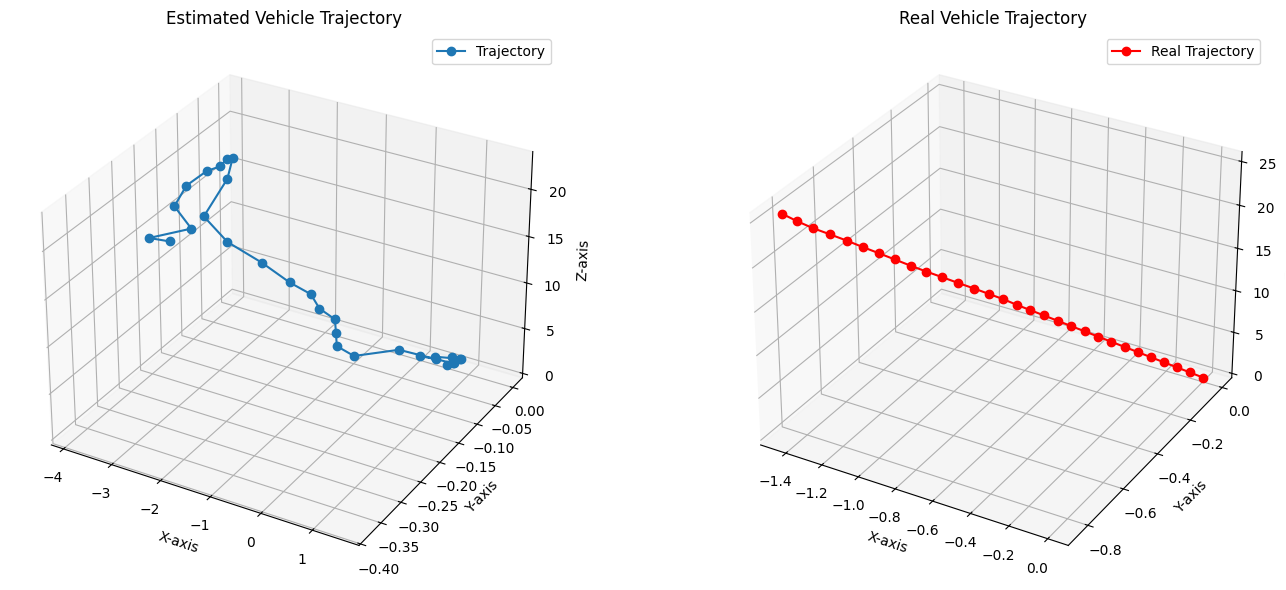

In [13]:
# Cria figura com dois gráficos 3D para comparação das trajetórias
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': '3d'})

# Processa a trajetória estimada
trajectory_array = np.array(trajectory)
x_coords = trajectory_array[:, 0, 3]  # Extrai coordenada X
y_coords = trajectory_array[:, 2, 3]  # Extrai coordenada Y (ajustada)
z_coords = trajectory_array[:, 1, 3] * -1  # Extrai coordenada Z com inversão

# Plota trajetória estimada
ax1.plot(x_coords, y_coords, z_coords, marker='o', label='Trajectory')
ax1.set_title('Estimated Vehicle Trajectory')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
ax1.legend()

# Extrai as coordenadas da trajetória real
x_real = ground_truth[:, 0, 3]
y_real = ground_truth[:, 1, 3]
z_real = ground_truth[:, 2, 3]

# Plota trajetória real
ax2.plot(x_real, y_real, z_real, marker='o', label='Real Trajectory', color='red')
ax2.set_title('Real Vehicle Trajectory')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_zlabel('Z-axis')
ax2.legend()

plt.tight_layout()
plt.show()